In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pickle import load
from pathlib import Path
from multipec.simulation_utils import set_plotting_style

def find_repo_root(marker="setup.py"):
    path = Path.cwd()
    while not (path / marker).exists() and path != path.parent:
        path = path.parent
    return path

project_root = find_repo_root()

In [8]:
ext = "_34"

results_folder = project_root/"data/results/cnn/"
figures_folder = project_root/"data/figures/cnn/"

filename_model = f"pruned{ext}.xlsx"
filename_random = "pruned_random_100runs.xlsx"

IDX_TO_LABEL = {0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}

Load the class-specific accuracy change. Skip the first row as it contains NaNs (this is a manually added row containing the original model's accuracy values).

In [9]:
df_model = pd.read_excel(results_folder/filename_model, usecols="R:AA", skiprows=lambda x:x in [1])
df_random = pd.read_excel(results_folder/filename_random, usecols="R:AA", skiprows=lambda x:x in [1])

Load subnets:

In [10]:
output_path = project_root/"data/output/cnn/"

conv_layers = {2:10, 3:20}

loaded_nets = load(open(output_path/f"nets{ext}.p", "rb"))

idx_net_dict, idx_err_dict = {}, {}
net_err_dict = {}
idx=0
for n in loaded_nets:
    if len(n[0])>2: # consider only nets (not pairs)

        net_err_dict[n[0]] = n[1][-1]

        idx_net_dict[idx] = n[0]
        idx_err_dict[idx] = n[1][-1]
        idx+=1

print("Number of subnets excluding pairs:", len(idx_net_dict))
print(idx_net_dict)

Number of subnets excluding pairs: 13
{0: (9, 4, 3, 2, 5), 1: (3, 5, 9, 8, 2), 2: (3, 6, 9, 5, 8), 3: (4, 2, 9, 6, 3, 5), 4: (4, 5, 9, 6, 3, 2), 5: (3, 2, 9, 8), 6: (0, 7, 9, 8, 16, 13, 20, 5), 7: (6, 5, 9, 2), 8: (12, 10, 16, 21, 13, 28, 26), 9: (2, 6, 4, 5), 10: (4, 3, 9, 6, 5), 11: (8, 9, 2, 3, 5), 12: (4, 6, 9, 5)}


Pruning which subnets most decreases the accuracy for each class? These subnets are most important for classification.

In [11]:
net_class_dict = {}
idx_class_dict = {}

for name, val in df_model.items():
    class_name = name[1::]
    idx = int(df_model[[name]].idxmin().iloc[0])
    d_accuracy = min(val)

    net = idx_net_dict[idx]

    if net not in net_class_dict:
        net_class_dict[net] = [class_name]
    else:
        net_class_dict[net].append(class_name)

    if idx not in idx_class_dict:
        idx_class_dict[idx] = [(class_name, d_accuracy)]
    else:
        idx_class_dict[idx].append((class_name, d_accuracy))

print(net_class_dict)
print(idx_class_dict)


{(3, 6, 9, 5, 8): ['0 - zero', '1 - one', '2 - two', '4 - four', '5 - five', '6 - six', '7 - seven', '9 - nine'], (0, 7, 9, 8, 16, 13, 20, 5): ['3 - three'], (4, 2, 9, 6, 3, 5): ['8 - eight']}
{2: [('0 - zero', -86.02040816), ('1 - one', -95.24229075), ('2 - two', -21.99612403), ('4 - four', -80.75356415), ('5 - five', -17.04035874), ('6 - six', -77.97494781), ('7 - seven', -34.72762646), ('9 - nine', -36.17443013)], 6: [('3 - three', -11.48514851)], 3: [('8 - eight', -83.57289528)]}


Networks identified by eye as class-specific across PEC ranges:

4down - too small accuracy change

34 - Net #1 class 8

23 - Net #7 class 1; Net #12 class 2

12 - Net #1 or Net #21 class 1;  Net #13 or Net#26 class 9 

In [14]:
class_net_index = 0

COI = "Δ8 - eight"

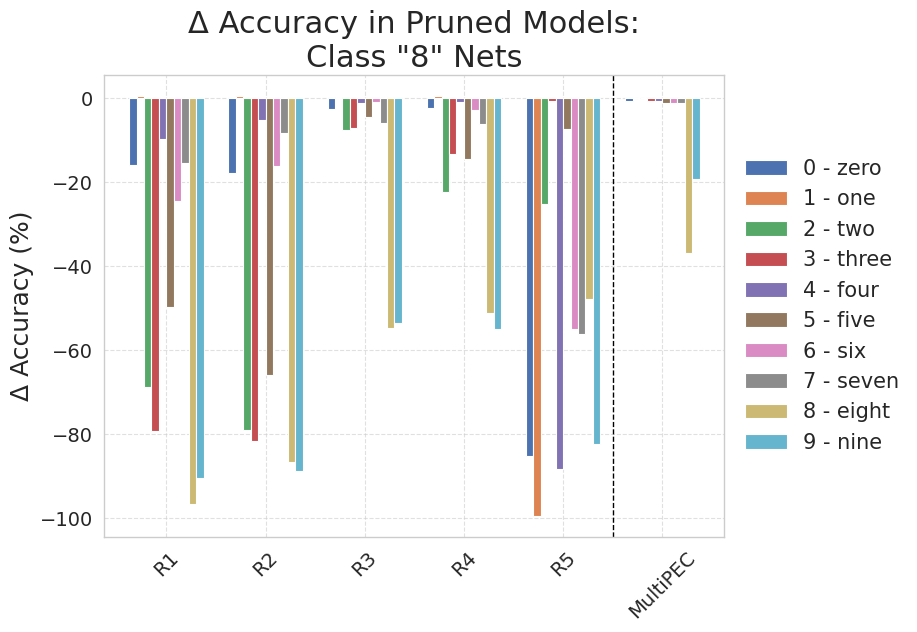

In [21]:
set_plotting_style()

to_plot = df_random.sort_values(by=[COI], axis=0).iloc[0:5]
to_plot = pd.concat([to_plot, df_model.iloc[[class_net_index]]])

ax = to_plot.plot(kind='bar', width=0.75)

# Custom x-axis tick labels
xtick_labels = [f"Random Net {i+1}" for i in range(5)] + ["MultiPEC Net"]
ax.set_title(f'Δ Accuracy in Pruned Models:\nClass "{COI[1]}" Nets')
ax.set_xticks(range(6))
ax.set_ylabel("Δ Accuracy (%)")

xtick_labels = [f"R{i+1}" for i in range(5)] + ["MultiPEC"]
ax.set_xticklabels(xtick_labels, rotation=45)



# Trim legend labels (remove first character from each label)
handles, labels = ax.get_legend_handles_labels()
trimmed_labels = [label[1:] for label in labels]
ax.legend(handles, trimmed_labels, loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
ax.axvline(x=4.5, color='black', linestyle='--', linewidth=1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig(figures_folder / f"Class_{COI[1]}_Accuracy_Random.png", dpi=300)

plt.show()


In [9]:
df_random.sort_values(by=[COI], axis=0).iloc[0:5]

,Δ0 - zero,Δ1 - one,Δ2 - two,Δ3 - three,Δ4 - four,Δ5 - five,Δ6 - six,Δ7 - seven,Δ8 - eight,Δ9 - nine
35,-17.755102,0.440529,-78.875969,-81.485149,-5.193483,-65.807175,-16.179541,-8.268482,-86.550308,-88.800793
50,-15.918367,0.528634,-68.798450,-79.306931,-9.775967,-49.775785,-24.530271,-15.564202,-96.509240,-90.386521
21,-21.020408,-70.660793,-36.240310,-60.198020,-26.069246,-11.883408,-22.546973,-8.268482,0.821355,-49.058474
29,-3.265306,-0.440529,-16.472868,-34.059406,-4.480652,-23.878924,-3.027140,-6.906615,-23.716632,-43.904856
71,-2.755102,0.352423,-34.496124,-17.128713,-1.018330,-29.708520,-2.818372,-4.571984,-36.652977,-25.966303


In [10]:
df_model.iloc[[class_net_index]]

,Δ0 - zero,Δ1 - one,Δ2 - two,Δ3 - three,Δ4 - four,Δ5 - five,Δ6 - six,Δ7 - seven,Δ8 - eight,Δ9 - nine
2,-1.22449,-1.674009,-0.484496,-11.485149,-2.851324,-1.121076,0.417537,-3.404669,-1.129363,-13.676908
